In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch.utils.data as utils
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import tensorflow as tf

In [2]:
# Import Dataset
qcd_raw = pd.read_csv('../HiggsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../HiggsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

print(len(qcd_raw), "rows of qcd data")
print(len(hh_raw), "rows of dihiggs data")

1703 rows of qcd data
4605 rows of dihiggs data


In [3]:
# drop unwanted rows from dataframe
hh_raw = hh_raw.drop(columns=['isMatchable', 
                              'met', 'met_phi', 
                              'nJets', 
                              'nBTags']);
qcd_raw = qcd_raw.drop(columns=['isMatchable', 
                                'met', 'met_phi', 
                                'nJets', 
                                'nBTags']);

In [4]:
hh_all = np.array(hh_raw); qcd = np.array(qcd_raw); n_factors = np.shape(hh_all)[1]; print(n_factors)
image_dim = (7,7,3)

49


In [5]:
# add labels to di-higgs
hh_all=hh_all[:,:n_factors]
hh_labels= np.zeros((len(hh_all),1))
hh_labels = hh_labels+1
hh_all = np.append(hh_all, hh_labels, axis=1)
hh_all = np.append(hh_all, 1-hh_labels, axis=1)## hh qcd labels 

qcd=qcd[:,:n_factors]
qcd_labels= np.zeros((len(qcd),1))
qcd = np.append(qcd, qcd_labels, axis=1) 
qcd = np.append(qcd, 1-qcd_labels, axis=1)# qcd qcd labels

hh = hh_all[0:len(qcd)]

all_data = np.append(hh,qcd, axis=0) 

np.random.seed(0)

all_labels = all_data[:,n_factors:]

all_data = all_data[:,:n_factors]

# scale the data by dividing it by the max value of each
for i in range(np.shape(all_data)[1]):
    all_data[:,i] = np.true_divide(all_data[:,i], np.max(all_data[:,i]))
all_data.shape

(3406, 49)

In [6]:
value = np.empty((), dtype=object)
value[()] = (0, 0, 0)
all_data_as_pixels = np.zeros((all_data.shape[0], all_data.shape[1], 3), dtype=np.uint8)
for i in range(np.shape(all_data)[1]): 
    for j in range(len(all_data[i])):
#         print(all_data_as_pixels[i][j].shape)
        feature = all_data[i][j]
        all_data_as_pixels[i][j][0] = 255*feature
        all_data_as_pixels[i][j][1] = 255*feature
        all_data_as_pixels[i][j][2] = 255*feature
print(all_data_as_pixels.shape)

(3406, 49, 3)


In [7]:
images = []
images_and_labels = []

for pixels, labels in zip(all_data_as_pixels, all_labels):
    ''' zipping ensures that images array and labels array are the same length '''
    img = pixels.reshape(image_dim[0],image_dim[1],3)
    images.append(img)
print(images[0].shape)
img_0 = Image.fromarray(images[0], 'RGB')
img_dataset = [Image.fromarray(img, 'RGB') for img in images]
img_0

(7, 7, 3)


[1. 0.]


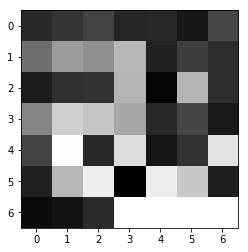

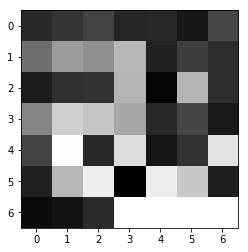

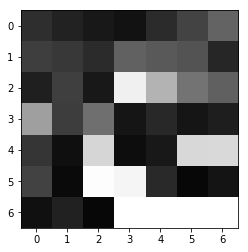

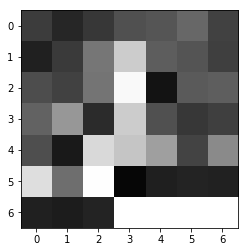

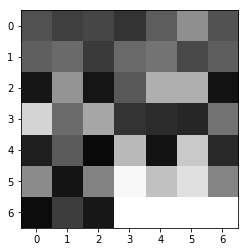

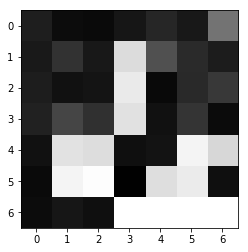

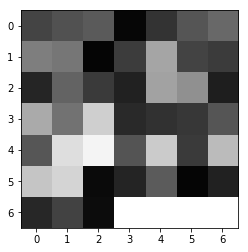

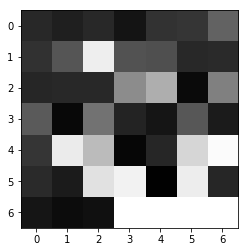

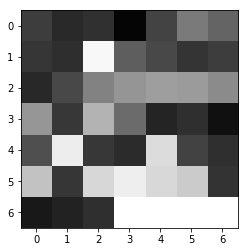

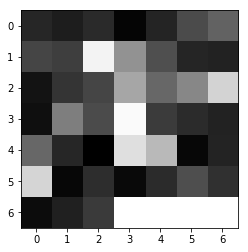

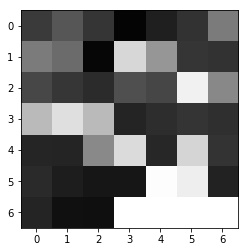

In [28]:
plt.imshow(images[0], cmap='Greys')
print(all_labels[0])
plt.show()
plt.close()
for i in range(10): 
    plt.imshow(images[i], cmap='Greys')
    plt.show()
    plt.close()

In [20]:
x_train, x_test, y_train, y_test = train_test_split(images, all_labels, test_size=0.33, random_state=42)
# train_dataset = tf.data.Dataset.from_tensor_slices((np.array(images), all_labels))
print(len(x_train))

2282


In [10]:
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

[1. 0.]
(7, 7, 3)


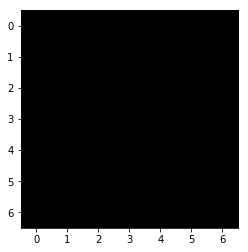

In [29]:
#%matplotlib inline # Only use this if using iPython
image_index = 0 # You may select anything up to 2,282
print(y_train[image_index]) # The label is 8
print(x_train[image_index].shape)
plt.imshow(x_train[1], cmap='Greys')
# for some reason these are showing up black and it's not clear why 

In [17]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [18]:
# Reshaping the array to 4-dims so that it can work with the Keras API
img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

AttributeError: 'list' object has no attribute 'reshape'

In [14]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)
model.evaluate(x_test, y_test)

Using TensorFlow backend.
W0724 20:44:43.593445 4642796992 deprecation_wrapper.py:119] From /Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 20:44:43.678588 4642796992 deprecation_wrapper.py:119] From /Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 20:44:43.746491 4642796992 deprecation_wrapper.py:119] From /Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 20:44:43.800123 4642796992 deprecation_wrapper.py:119] From /Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max

Epoch 1/10
59744/60000 [============================>.] - ETA: 0s - loss: 0.2093 - acc: 0.9361

KeyboardInterrupt: 

In [ ]:
image_index = 4444

plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, img_rows, img_cols, 1))
print(pred.argmax())